In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,Input,SeparableConv2D,BatchNormalization
from tensorflow.keras import optimizers
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import cv2 as cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys,os, itertools
import tqdm
import shutil
%matplotlib inline

## PRE-PROCESSING

In [17]:
BASE_DIR = 'dataset/'
C1 = BASE_DIR + "C1/"
C2 = BASE_DIR + "C2/"
C3 = BASE_DIR + "C3/"

files_C1 = sorted(os.listdir(C1))
files_C2 = sorted(os.listdir(C2))
files_C3 = sorted(os.listdir(C3))

df = pd.DataFrame()

path_iamge = []


path = [C1+ str(x) for x in files_C1]+[C2+ str(x) for x in files_C2]+[C3+ str(x) for x in files_C3]
label = [label.split('/')[1] for label in path ]

df['path'] = path
df['label'] = label

df.to_csv('data/data.csv', columns=['path','label'],index=False)

In [18]:
path_data = 'data/data.csv'
df_data = pd.read_csv(path_data)

In [19]:
df_data.head()

,path,label
0,dataset/C1/1- kanan c1 - kiri c-1.png,C1
1,dataset/C1/102 kanan c1 kiri c3.png,C1
2,dataset/C1/105 - kanan kiri c1.png,C1
3,dataset/C1/106 - kanan c1 - kiri c2.png,C1
4,dataset/C1/107 - kanan kiri c1.png,C1


In [20]:
jumlah_label = df['label'].value_counts()
jumlah_label

C1    79
C2    74
C3    29
Name: label, dtype: int64

<AxesSubplot:>

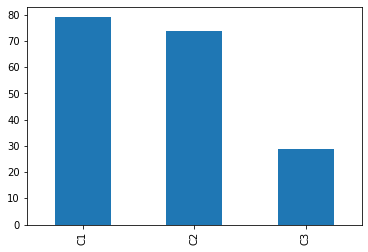

In [21]:
jumlah_label.plot.bar()

In [22]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo

In [23]:
def Visualize_class(df, feature, title):
    num_image = df[feature].value_counts().rename_axis(feature).reset_index(name="jenis")
    fig = px.bar(num_image[::1], x="jenis", y=feature, orientation='h', color='jenis')
    fig.update_layout(
        title={
            'text' : title,
            'y' : 0.95,
            'x' : 0.5,
            'xanchor' : 'center',
            'yanchor' : 'top'})
    fig.show()

In [24]:
Visualize_class(df_data, feature="label", title="Pembagian label")

In [25]:
def scaleImage(path):
    
    img = cv2.imread(path)
    img = cv2.medianBlur(img,5)
    
    scale_percent = 10 # percent of original size
    width = int(img.shape[1])
    height = int(img.shape[0])
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim,cv2.COLOR_BGR2RGB)
    
    print('Resized Dimensions : ',resized.shape)

    plt.imshow(resized)
    plt.show()
    
    print('Grayscale Image: ')
    
    img_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(img_gray)
    plt.show()
    
    print('CLAHE Image: ')
    
    ycrcb = cv2.cvtColor(resized, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe.apply(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, resized)
    
    plt.imshow(resized)
    plt.show()
    
    print('RGB to HSV: ')
    print(resized)
    img_rgb_hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    plt.imshow(img_rgb_hsv)
    plt.show()
    
    
#     print('Yellow color: ')
#     yellow_lower = np.array([20, 100, 100])
#     yellow_upper = np.array([30, 255, 255])
    
#     mask_yellow = cv2.inRange(img_rgb_hsv, yellow_lower, yellow_upper)

#     yellow_output = cv2.bitwise_and(img, img, mask=mask_yellow)

#     yellow_ratio =(cv2.countNonZero(mask_yellow))/(img.size/3)
    
#     plt.imshow(mask_yellow)
#     plt.show()
    
    print('Treshold image: ')
    ret, img_treshold = cv2.threshold(resized,127,255, cv2.THRESH_BINARY_INV)
    fig = plt.figure(figsize=(7,9),frameon=False)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    rgbImg = cv2.cvtColor(img_treshold, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(os.path.join('train/busuk/' , 'waka.jpg'), rgbImg)
    cv2.waitKey(0)
    plt.imshow(img_treshold)
    
#     plt.savefig('testss.png')
    plt.show()

Resized Dimensions :  (1250, 2800, 3)


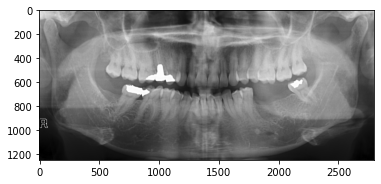

Grayscale Image: 


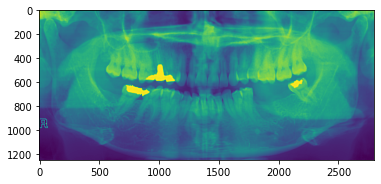

CLAHE Image: 


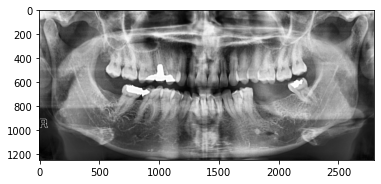

RGB to HSV: 
[[[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [241 241 241]
  [242 242 242]
  [242 242 242]]

 [[250 250 250]
  [250 250 250]
  [250 250 250]
  ...
  [241 241 241]
  [241 241 241]
  [242 242 242]]

 [[251 251 251]
  [250 250 250]
  [250 250 250]
  ...
  [241 241 241]
  [241 241 241]
  [242 242 242]]

 ...

 [[ 36  36  36]
  [ 36  36  36]
  [ 33  33  33]
  ...
  [  8   8   8]
  [ 11  11  11]
  [ 11  11  11]]

 [[ 36  36  36]
  [ 33  33  33]
  [ 33  33  33]
  ...
  [  8   8   8]
  [ 11  11  11]
  [ 11  11  11]]

 [[ 33  33  33]
  [ 33  33  33]
  [ 33  33  33]
  ...
  [  8   8   8]
  [  8   8   8]
  [  8   8   8]]]


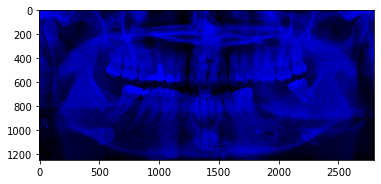

Treshold image: 


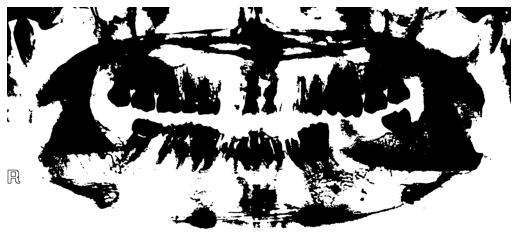

In [26]:
scaleImage(df_data['path'][19])

In [ ]:
def threshold(img):
    ret, img_treshold = cv2.threshold(img,127,255, cv2.THRESH_BINARY_INV)
    return img_treshold

In [68]:
def read_img(path):
    img = cv2.imread(path)
#     img = cv2.medianBlur(img,5)
    return img

In [69]:
def scale_img(img,scale=10):
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, (390,220),cv2.COLOR_BGR2RGB)
    return resized

In [70]:
def grayscale(img):
    img_gray =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

In [71]:
def rgb_hsv(img):
    img_rgb_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img_rgb_hsv

In [72]:
def clahe(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe.apply(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    
    return img

,path,label
0,data_baru/training/C1/1- kanan c1_01.png,C1
1,data_baru/training/C1/kanan-c1-17.png,C1
2,data_baru/training/C1/kanan-c1-18.png,C1
3,data_baru/training/C1/kanan-c1-19.png,C1
4,data_baru/training/C1/kanan-c1-20.png,C1
...,...,...
300,data_baru/training/C3/kiri-c3-24.jpg,C3
301,data_baru/training/C3/kiri-c3-25.jpg,C3
302,data_baru/training/C3/kiri-c3-26.jpg,C3
303,data_baru/training/C3/kiri-c3-30.jpg,C3


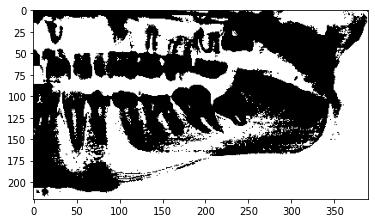

In [73]:
newPathCSV = []
newLabelCSV = []
newDf = pd.DataFrame()
for i in range(len(df_data)):
    
    FOLDER_TRAIN = 'data_baru/training/'
    label = df_data['path'][i].split('/')[1]
    fileName = df_data['path'][i].split('/')[2]
    newPath = FOLDER_TRAIN+label+'/'
    
    img = read_img(df_data['path'][i])
    img = scale_img(img)
    img = clahe(img)
    img = threshold(img)
    plt.imshow(img)
    rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(os.path.join(newPath , fileName), rgbImg)
    cv2.waitKey(0)
#     plt.savefig(newPath)
    
    newPathCSV.append(newPath+fileName)
    newLabelCSV.append(label)
    

newDf['path'] = newPathCSV
newDf['label'] = newLabelCSV

newDf.to_csv('data/data_prepro.csv', columns=['path','label'],index=False)
    
newDf

## Data Augmentation

### Rotate

In [97]:
df_aug = pd.read_csv("data/data_prepro.csv")
df_aug

,path,label
0,data_baru/training/C1/1- kanan c1_01.png,C1
1,data_baru/training/C1/kanan-c1-17.png,C1
2,data_baru/training/C1/kanan-c1-18.png,C1
3,data_baru/training/C1/kanan-c1-19.png,C1
4,data_baru/training/C1/kanan-c1-20.png,C1
...,...,...
300,data_baru/training/C3/kiri-c3-24.jpg,C3
301,data_baru/training/C3/kiri-c3-25.jpg,C3
302,data_baru/training/C3/kiri-c3-26.jpg,C3
303,data_baru/training/C3/kiri-c3-30.jpg,C3


In [129]:
file_C = []

In [130]:
for filename in os.listdir("data_baru/train/train/C3"):
    pathTrain = "data_baru/train/train/C3/"
    filepath = pathTrain+filename
    file_C.append(filepath)

In [131]:
file_C

['data_baru/train/train/C3/kanan-c3-01.png',
 'data_baru/train/train/C3/kanan-c3-02.jpg',
 'data_baru/train/train/C3/kanan-c3-03.jpeg',
 'data_baru/train/train/C3/kanan-c3-06.jpg',
 'data_baru/train/train/C3/kanan-c3-07.png',
 'data_baru/train/train/C3/kanan-c3-09.png',
 'data_baru/train/train/C3/kanan-c3-10.png',
 'data_baru/train/train/C3/kanan-c3-11.jpg',
 'data_baru/train/train/C3/kanan-c3-119.jpg',
 'data_baru/train/train/C3/kanan-c3-12.jpg',
 'data_baru/train/train/C3/kanan-c3-13.jpg',
 'data_baru/train/train/C3/kanan-c3-14.jpg',
 'data_baru/train/train/C3/kanan-c3-15.jpg',
 'data_baru/train/train/C3/kanan-c3-17.jpg',
 'data_baru/train/train/C3/kanan-c3-20.jpg',
 'data_baru/train/train/C3/kanan-c3-21.jpg',
 'data_baru/train/train/C3/kanan-c3-22.jpg',
 'data_baru/train/train/C3/kanan-c3-23.jpg',
 'data_baru/train/train/C3/kanan-c3-24.jpg',
 'data_baru/train/train/C3/kanan-c3-25.jpeg',
 'data_baru/train/train/C3/kanan-c3-26.jpg',
 'data_baru/train/train/C3/kanan-c3-27.jpg',
 'data_

In [132]:
def rotate_image(image,angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    height, width = image.shape[:2]  # image shape has 3 dimensions
    image_center = (width / 2, height / 2)  # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0, 0])
    abs_sin = abs(rotation_mat[0, 1])
    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)
    # subtract old image center (bringing image back to origin) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w / 2 - image_center[0]
    rotation_mat[1, 2] += bound_h / 2 - image_center[1]
    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
    return rotated_mat

data_baru/train/train/C3/kanan-c3-01_340.png
data_baru/train/train/C3/kanan-c3-02_180.jpg
data_baru/train/train/C3/kanan-c3-03_340.jpeg
data_baru/train/train/C3/kanan-c3-06_180.jpg
data_baru/train/train/C3/kanan-c3-07_340.png
data_baru/train/train/C3/kanan-c3-09_180.png
data_baru/train/train/C3/kanan-c3-10_340.png
data_baru/train/train/C3/kanan-c3-11_180.jpg
data_baru/train/train/C3/kanan-c3-119_340.jpg
data_baru/train/train/C3/kanan-c3-12_180.jpg
data_baru/train/train/C3/kanan-c3-13_340.jpg
data_baru/train/train/C3/kanan-c3-14_180.jpg
data_baru/train/train/C3/kanan-c3-15_340.jpg
data_baru/train/train/C3/kanan-c3-17_180.jpg
data_baru/train/train/C3/kanan-c3-20_340.jpg
data_baru/train/train/C3/kanan-c3-21_180.jpg
data_baru/train/train/C3/kanan-c3-22_340.jpg
data_baru/train/train/C3/kanan-c3-23_180.jpg
data_baru/train/train/C3/kanan-c3-24_340.jpg
data_baru/train/train/C3/kanan-c3-25_180.jpeg
data_baru/train/train/C3/kanan-c3-26_340.jpg
data_baru/train/train/C3/kanan-c3-27_180.jpg
data_ba

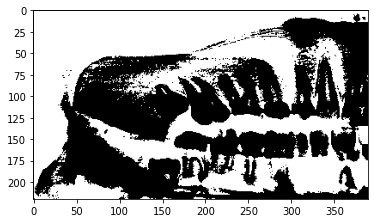

In [133]:
angles = [340, 180]
for i in range(len(file_C)):
    angle = i % 2
    filename = file_C[i].split('.')[0]
    ext = file_C[i].split('.')[-1]
    newPath = filename+"_"+str(angles[angle])+"."+ext
    print(newPath)
    img = cv2.imread(file_C[i],1)
    img_rotate = rotate_image(img, angles[angle])
    plt.imshow(img_rotate)
    cv2.imwrite(newPath, img_rotate)
    cv2.waitKey(0)
    

## Split dataset using K-Fold

In [74]:
def split_df(df):
  kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=89)
  df['id'] = df.index
  annot_pivot = pd.pivot_table(df, index=['path'], columns=['label'], values='id', fill_value=0, aggfunc='count').reset_index().rename_axis(None, axis=1)
  for fold, (train_idx, val_idx) in enumerate(kf.split(annot_pivot, annot_pivot.iloc[:, 1:(1+df['label'].nunique())])):
    annot_pivot[f'fold_{fold}'] = 0
    annot_pivot.loc[val_idx, f'fold_{fold}'] = 1
  return annot_pivot

size_df = pd.read_csv('data/data_prepro.csv')
size_df.columns = ['path', 'label']

fold_csv = split_df(df_aug)
fold_csv = fold_csv.merge(size_df, on='path', how='left')
fold_csv.head(100)

,path,C1,C2,C3,fold_0,fold_1,fold_2,fold_3,fold_4,label
0,data_baru/training/C1/1- kanan c1_01.png,1,0,0,0,1,0,0,0,C1
1,data_baru/training/C1/kanan-c1-17.png,1,0,0,1,0,0,0,0,C1
2,data_baru/training/C1/kanan-c1-18.png,1,0,0,0,0,1,0,0,C1
3,data_baru/training/C1/kanan-c1-19.png,1,0,0,0,1,0,0,0,C1
4,data_baru/training/C1/kanan-c1-20.png,1,0,0,0,0,0,1,0,C1
...,...,...,...,...,...,...,...,...,...,...
95,data_baru/training/C1/kiri-c1-46.jpg,1,0,0,0,0,0,0,1,C1
96,data_baru/training/C1/kiri-c1-47.jpg,1,0,0,0,0,0,0,1,C1
97,data_baru/training/C1/kiri-c1-48.jpg,1,0,0,0,0,0,0,1,C1
98,data_baru/training/C1/kiri-c1-49.jpg,1,0,0,0,0,1,0,0,C1


In [75]:
list_image_train = fold_csv[fold_csv[f'fold_{1}'] == 0]['path']
train_df = df_aug[df_aug['path'].isin(list_image_train)].reset_index(drop=True)
val_df = df_aug[~df_aug['path'].isin(list_image_train)].reset_index(drop=True)

In [76]:
train_df

,path,label,id
0,data_baru/training/C1/kanan-c1-17.png,C1,1
1,data_baru/training/C1/kanan-c1-18.png,C1,2
2,data_baru/training/C1/kanan-c1-20.png,C1,4
3,data_baru/training/C1/kanan-c1-21.png,C1,5
4,data_baru/training/C1/kanan-c1-22.png,C1,6
...,...,...,...
239,data_baru/training/C3/kiri-c3-24.jpg,C3,300
240,data_baru/training/C3/kiri-c3-25.jpg,C3,301
241,data_baru/training/C3/kiri-c3-26.jpg,C3,302
242,data_baru/training/C3/kiri-c3-30.jpg,C3,303


In [80]:
def write_train_list(series):
    for path in series:
        split_path = path.split("/")
        filename = split_path[-1]
        loc = split_path[2]
        target = "data_baru/train/train/"+loc+"/"+filename
        print(target)
        if os.path.exists(path):    
          shutil.copyfile(path, target)

In [81]:
tr_series = train_df.path.unique() 
val_series = val_df.path.unique()

In [82]:
write_train_list(tr_series)

data_baru/train/train/C1/kanan-c1-17.png
data_baru/train/train/C1/kanan-c1-18.png
data_baru/train/train/C1/kanan-c1-20.png
data_baru/train/train/C1/kanan-c1-21.png
data_baru/train/train/C1/kanan-c1-22.png
data_baru/train/train/C1/kanan-c1-24.png
data_baru/train/train/C1/kanan-c1-25.png
data_baru/train/train/C1/kanan-c1-26.png
data_baru/train/train/C1/kanan-c1-28.png
data_baru/train/train/C1/kanan-c1-29.png
data_baru/train/train/C1/kanan-c1-30.png
data_baru/train/train/C1/kanan-c1-31.png
data_baru/train/train/C1/kanan-c1-32.png
data_baru/train/train/C1/kanan-c1-34.png
data_baru/train/train/C1/kanan-c1-35.png
data_baru/train/train/C1/kanan-c1-36.png
data_baru/train/train/C1/kanan-c1-37.png
data_baru/train/train/C1/kanan-c1-38.png
data_baru/train/train/C1/kanan-c1-40.png
data_baru/train/train/C1/kanan-c1-42.png
data_baru/train/train/C1/kanan-c1-43.png
data_baru/train/train/C1/kanan-c1-44.png
data_baru/train/train/C1/kanan-c1-45.jpg
data_baru/train/train/C1/kanan-c1-47.jpg
data_baru/train/

data_baru/train/train/C3/kanan-c3-25.jpeg
data_baru/train/train/C3/kanan-c3-26.jpg
data_baru/train/train/C3/kanan-c3-27.jpg
data_baru/train/train/C3/kanan-c3-28.jpg
data_baru/train/train/C3/kanan-c3-29.jpg
data_baru/train/train/C3/kiri-c3-01.png
data_baru/train/train/C3/kiri-c3-02.jpg
data_baru/train/train/C3/kiri-c3-03.jpg
data_baru/train/train/C3/kiri-c3-04.png
data_baru/train/train/C3/kiri-c3-06.png
data_baru/train/train/C3/kiri-c3-07.png
data_baru/train/train/C3/kiri-c3-09.png
data_baru/train/train/C3/kiri-c3-10.png
data_baru/train/train/C3/kiri-c3-100.png
data_baru/train/train/C3/kiri-c3-11.png
data_baru/train/train/C3/kiri-c3-12.jpg
data_baru/train/train/C3/kiri-c3-13.jpg
data_baru/train/train/C3/kiri-c3-14.jpg
data_baru/train/train/C3/kiri-c3-15.jpg
data_baru/train/train/C3/kiri-c3-16.jpg
data_baru/train/train/C3/kiri-c3-17.jpg
data_baru/train/train/C3/kiri-c3-19.jpg
data_baru/train/train/C3/kiri-c3-20.jpg
data_baru/train/train/C3/kiri-c3-22.jpg
data_baru/train/train/C3/kiri-c3-

### Augmentation Tensorflow

In [134]:
train_path = "data_baru/train/train"
test_path = "data_baru/train/test"

batch_size = 16

#The dimension of the images we are going to define is 500x500 
img_height = 300
img_width = 300

In [135]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_gen = ImageDataGenerator(rescale=1./255)

In [136]:
train_data_gen = data_gen.flow_from_directory(
    "data_baru/train/train",  # this is the target directory
    target_size=(300,300),  # all images will be resized to 300x300
    batch_size=batch_size,
    class_mode='categorical'  # since we use binary_crossentropy loss, we need binary labels
)

Found 488 images belonging to 3 classes.


In [137]:
test_data_gen = test_gen.flow_from_directory(
   "data_baru/train/test",
    target_size=(300,300),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 61 images belonging to 3 classes.


In [138]:
train_data_gen.image_shape

(300, 300, 3)

## Training

In [139]:
def modelNewCNN():
    classifier = Sequential()
    #1-Convolution
    classifier.add(Conv2D(32, (3,3), strides=(1,1), input_shape = (300,300,3), activation = 'relu'))
    #2-Pooling
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    #add second conv
    classifier.add(Conv2D(32, (3,3), strides=(1,1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    classifier.add(Conv2D(32, (3,3), strides=(1,1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    classifier.add(Conv2D(64, (3,3), strides=(1,1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    #add third conv
    classifier.add(Conv2D(64, (3,3), strides=(1,1), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2,2)))
    #3-Flattening
    classifier.add(Flatten())
    #4-Full Connection
    classifier.add(Dense(activation = 'relu', units = 900))
    classifier.add(Dense(activation = 'relu', units = 90))
    classifier.add(Dense(activation = 'softmax', units = 3))
    

    #Compiling CNN
    rmsprop = optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    classifier.compile(optimizer = rmsprop, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    classifier.summary()
    
    return classifier

In [140]:
model = modelNewCNN()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 32)      

In [11]:
def build_model():
    input_img = Input(shape=train_data_gen.image_shape, name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model

In [12]:
model= build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 150, 150, 128)    8896      
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 150, 150, 128)    17664 

In [13]:
batch_size = 16
epochs = 50
early_stop = EarlyStopping(patience=25,
                           verbose = 2,
                           monitor='val_loss',
                           mode='auto')

checkpoint = ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    verbose = 1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=1, 
    min_lr=0.0001
)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=0.0001))

history = model.fit_generator(epochs=epochs,
                              callbacks=[early_stop,checkpoint,reduce],
                              shuffle=True,
                              validation_data=test_data_gen,
                              generator=train_data_gen,
                              steps_per_epoch=292//batch_size,
                              validation_steps=36//batch_size,
                              verbose=2)

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-13-0a89ac3140d7>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(epochs=epochs,


Epoch 1/50


KeyboardInterrupt: 

In [93]:
def save_grafik(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('data/accuracy.png')
    plt.close()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('data/loss.png')
    plt.close()
    
    return "Save Successful"

In [141]:
history_callback = model.fit(
        train_data_gen,
        steps_per_epoch=244//batch_size,
        epochs=50,
        validation_data=test_data_gen,
        validation_steps=61//batch_size)

model.save('data/model_new.h5')  # always save your weights after training or during training

loss_history = history_callback.history["loss"]
accuracy_history = history_callback.history["accuracy"]
val_loss_history = history_callback.history["val_loss"]
val_accuracy_history = history_callback.history["val_accuracy"]

numpy_loss_history = np.array(loss_history)
np.savetxt("data/loss_history.txt", numpy_loss_history, delimiter=",")
#return numpy_loss_history
numpy_accuracy_history = np.array(accuracy_history)
np.savetxt("data/acc_history.txt", numpy_accuracy_history, delimiter=",")

numpy_val_loss_history = np.array(val_loss_history)
np.savetxt("data/val_loss_history.txt", numpy_val_loss_history, delimiter=",")
#return numpy_loss_history
numpy_val_accuracy_history = np.array(val_accuracy_history)
np.savetxt("data/val_acc_history.txt", numpy_val_accuracy_history, delimiter=",")

save_grafik(history=history_callback)

Epoch 1/50
15/15 [==============================] - 13s 773ms/step - loss: 1.0813 - accuracy: 0.3625 - val_loss: 0.9022 - val_accuracy: 0.6042
Epoch 2/50
15/15 [==============================] - 12s 816ms/step - loss: 1.0354 - accuracy: 0.4698 - val_loss: 0.8595 - val_accuracy: 0.7292
Epoch 3/50
15/15 [==============================] - 14s 890ms/step - loss: 1.0061 - accuracy: 0.5125 - val_loss: 0.7884 - val_accuracy: 0.6458
Epoch 4/50
15/15 [==============================] - 13s 864ms/step - loss: 0.9691 - accuracy: 0.5862 - val_loss: 0.8218 - val_accuracy: 0.6250
Epoch 5/50
15/15 [==============================] - 14s 893ms/step - loss: 0.9424 - accuracy: 0.5583 - val_loss: 0.9324 - val_accuracy: 0.6250
Epoch 6/50
15/15 [==============================] - 13s 867ms/step - loss: 0.9548 - accuracy: 0.5345 - val_loss: 0.8946 - val_accuracy: 0.4792
Epoch 7/50
15/15 [==============================] - 14s 913ms/step - loss: 0.9308 - accuracy: 0.5625 - val_loss: 0.8923 - val_accuracy: 0.7292

'Save Successful'

## Loss and Accuracy Model

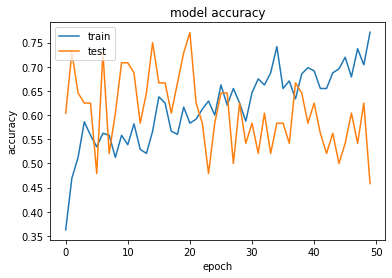

In [142]:
plt.plot(history_callback.history['accuracy'])
plt.plot(history_callback.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.close()

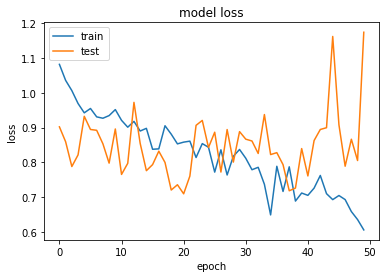

In [143]:
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.close()

In [83]:
from tensorflow.keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(300, 300))
    img = (np.asarray(img))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    return img_tensor

predImage = load_image('dataset/test/C2/IMG_4191.jpg')
# predImage
pred = model.predict(predImage)
pred

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/test/C2/IMG_4191.jpg'

## Load Model and Prediction Images

In [110]:
def loadModel(path):
    model_loaded = load_model(path)
    print(model_loaded)
    rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_loaded.compile(loss='categorical_crossentropy',
                optimizer=rmsprop,
                metrics=['accuracy'])
    model_loaded.summary()
    return 'Load Model Successfull'

In [111]:
modelPredict = loadModel('data/train_10/model_new.h5')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 35, 35, 32)      

C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [273]:
predImage = load_image('dataset/test/C2/100 - kanan kiri c2.png')
# predImage
pred = model.predict(predImage)
pred

array([[5.9313226e-29, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [274]:
test_data_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [275]:
test_data_gen

In [112]:
Y_pred = model.predict(test_data_gen,  // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

## Confusion Matrix

In [114]:
#Confution Matrix and Classification Report
Y_pred = model.predict(test_data_gen,36 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['C1', 'C2', 'C3']
print(classification_report(test_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 5 11  0]
 [ 0 13  1]
 [ 0  6  0]]
Classification Report
              precision    recall  f1-score   support

          C1       1.00      0.31      0.48        16
          C2       0.43      0.93      0.59        14
          C3       0.00      0.00      0.00         6

    accuracy                           0.50        36
   macro avg       0.48      0.41      0.36        36
weighted avg       0.61      0.50      0.44        36



In [116]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('data/train_10/confusion_matrix.png')

Normalized confusion matrix


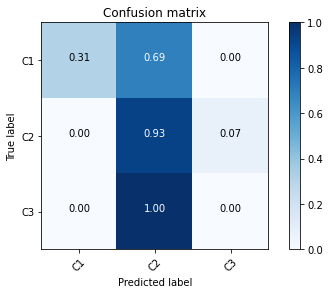

In [117]:
cm = confusion_matrix(test_data_gen.classes, y_pred)
plot_confusion_matrix(cm,target_names,normalize=True)